# Weather API Project

## Griffin Brown

In [51]:
import requests
import pandas as pd
import pgeocode
import json
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objects as go

### Convert Zip

I want the user to be able to put in a zip code and see the forcast. Using NOAA API weather service, I need a latitude and longitude, so I'll need to convert the user input.

In [14]:
nomi = pgeocode.Nominatim('us')
query = nomi.query_postal_code("84098")

lat = query["latitude"]
lon = query["longitude"]

### First Request

The first request returns details for this lat/lon, with several other API endpoints.

In [15]:
url = f'https://api.weather.gov/points/{lat},{lon}'

response = requests.get(url)

if response.status_code == 200:
    response_json = response.json()
    #print(json.dumps(response_json, indent=4))
    forecast_url = response_json['properties']['forecast']
else:
    print(f"Error: Unable to fetch data, status code {response.status_code}")

In [16]:
forecast_response = requests.get(forecast_url)

### Creating Interpretable Dataframe

The next part will involve parsing the json string and appending to a dataframe.

In [17]:
if forecast_response.status_code==200:
    forecast_json = forecast_response.json()
    
    periods = forecast_json['properties']['periods']
    
    dates = []
    is_day_time = []
    temps = []
    short_forecasts = []
    detailed_forecasts = []
    
    for period in periods:
        start_time = period['startTime']
        date = start_time.split('T')[0]  # Extract the date part
        date = pd.to_datetime(date).strftime('%m/%d/%Y')  # Format the date

        dates.append(date)
        is_day_time.append(period['isDaytime'])
        temps.append(period['temperature'])
        short_forecasts.append(period['shortForecast'])
        detailed_forecasts.append(period['detailedForecast'])
    
    # Create a DataFrame
    weather_df = pd.DataFrame({
        'Date': dates,
        'Day Time': is_day_time,
        'Temp': temps,
        'Short Forecast': short_forecasts,
        'Detailed Forecast': detailed_forecasts
    })
    
    # Display the DataFrame
    print(weather_df)
    
else:
    print(f"Error: Unable to fetch data, status code {forecast_response.status_code}")

          Date  Day Time  Temp  \
0   05/29/2024      True    73   
1   05/29/2024     False    36   
2   05/30/2024      True    63   
3   05/30/2024     False    39   
4   05/31/2024      True    72   
5   05/31/2024     False    47   
6   06/01/2024      True    78   
7   06/01/2024     False    49   
8   06/02/2024      True    74   
9   06/02/2024     False    48   
10  06/03/2024      True    75   
11  06/03/2024     False    49   
12  06/04/2024      True    72   
13  06/04/2024     False    46   

                                       Short Forecast  \
0             Slight Chance Showers And Thunderstorms   
1   Chance Showers And Thunderstorms then Mostly C...   
2                                               Sunny   
3                                        Mostly Clear   
4                                               Sunny   
5                                       Partly Cloudy   
6                                        Mostly Sunny   
7                                

### Creating Visuals

From here, we can create simple visuals for the user.

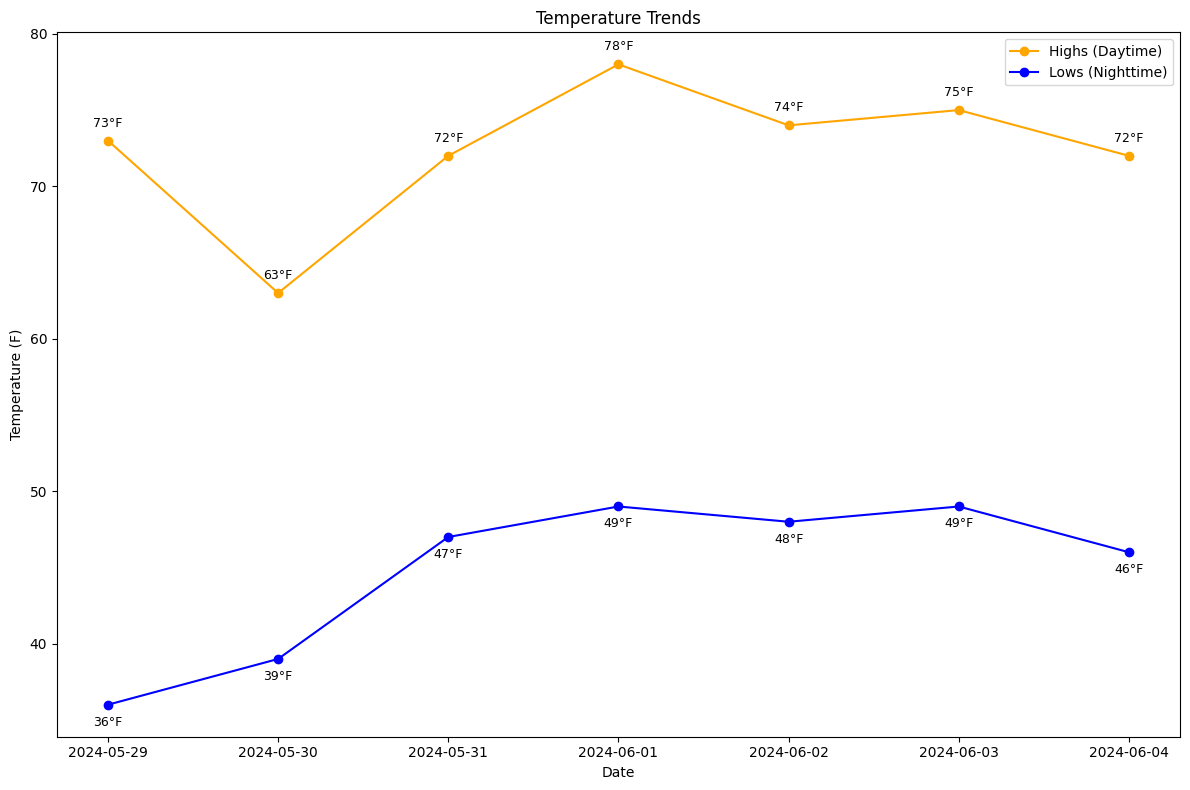

In [21]:
daytime_temps = weather_df[weather_df['Day Time'] == True]
nighttime_temps = weather_df[weather_df['Day Time'] == False]

weather_df['Date'] = pd.to_datetime(weather_df['Date'])

plt.figure(figsize=(12, 8))
plt.plot(daytime_temps['Date'], daytime_temps['Temp'], label='Highs (Daytime)', color='orange', marker='o')
for i in range(len(daytime_temps)):
    plt.annotate(f"{daytime_temps.iloc[i]['Temp']}°F", 
                 (daytime_temps.iloc[i]['Date'], daytime_temps.iloc[i]['Temp']), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', 
                 fontsize=9)
plt.plot(nighttime_temps['Date'], nighttime_temps['Temp'], label='Lows (Nighttime)', color='blue', marker='o')
for i in range(len(nighttime_temps)):
    plt.annotate(f"{nighttime_temps.iloc[i]['Temp']}°F", 
                 (nighttime_temps.iloc[i]['Date'], nighttime_temps.iloc[i]['Temp']), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center', 
                 fontsize=9)
plt.title('Temperature Trends')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend()
plt.xticks()
plt.grid(False)
plt.tight_layout()
plt.show()

In [32]:

weather_df['Day/Night'] = weather_df['Day Time'].apply(lambda x: 'Day' if x else 'Night')
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.strftime('%m/%d/%Y')

fig = go.Figure(data=[go.Table(
    header=dict(values=list(weather_df[['Date', 'Day/Night', 'Short Forecast', 'Detailed Forecast']].columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[weather_df['Date'], weather_df['Day/Night'], weather_df['Short Forecast'], weather_df['Detailed Forecast']],
               fill_color='lightblue',
               align='left'))
])
fig.update_layout(title='Weather Forecast', title_x=0.5)
fig.show()

In [52]:
weather_df['Day/Night'] = weather_df['Day Time'].apply(lambda x: 'Day' if x else 'Night')
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.strftime('%m/%d/%Y')

# Select the columns to display
display_df = weather_df[['Date', 'Day/Night', 'Short Forecast', 'Detailed Forecast']]

# Print the table using tabulate
print(tabulate(display_df, headers='keys', tablefmt='psql'))

+----+------------+-------------+----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Date       | Day/Night   | Short Forecast                                     | Detailed Forecast                                                                                                                                                                                     |
|----+------------+-------------+----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | 05/29/2024 | Day         | Slight Chance Showers And Thunderstorms            | A slight chance of showers and thunderstorms. Mostly